# Exploratory Data Analysis

## Music Style Classification

In this notebook I'm analyzing the results of the models classifying mood, style, and genres in the music.

All of the models featured in this notebook were trained on 1280-dim embeddings produced by the [discogs-effnet model](https://essentia.upf.edu/models/music-style-classification/discogs-effnet/discogs-effnet-bs64-1.json)

In [14]:
#Imports
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
from tqdm import tqdm
import pathlib
import librosa
import taglib
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_colwidth', 100)
plt.style.use("ggplot")

In [2]:
#Imports from project package called project_tools
from project_tools.utils import adapt_array, convert_array, tag_cleaner, json_opener

In [3]:
#Register these functions with sqlite3 so that we I can work with 
sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

In [4]:
#Connect to db
conn = sqlite3.connect("../jaage.db", detect_types= sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()

I'll be analyzing data from the following tables

In [121]:
tables = ['approachability_2c_effnet_discogs_1_activations',
 'danceability_effnet_discogs_1_activations',
 'engagement_2c_effnet_discogs_1_activations',
 'mood_acoustic_effnet_discogs_1_activations',
 'mood_aggressive_effnet_discogs_1_activations',
 'mood_happy_effnet_discogs_1_activations',
 'mood_party_effnet_discogs_1_activations',
 'mood_sad_effnet_discogs_1_activations']

Load in tags data 

In [6]:
tags = pd.read_sql_query("SELECT * FROM tags", con = conn).set_index("sid")
tags.head(5)

,length,gain,codec,file_name,bpm,initialkey,title,album,artist,date,genre,label
sid,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,287.393372,-9.895140,pcm_s16le,04 House Of Love_PN.wav,119.0,6A,04 House Of Love_PN,None,None,None,None,None
46e54d2ab920a088b77382e04877141b,311.251892,-11.281836,pcm_s16le,Alex Virgo - Rough N' Ready Edits - 06 A.T.S - Baa Daa Laa (Alex Virgo's Rough n Ready edit)_PN.wav,128.0,1A,A.T.S - Baa Daa Laa (Alex Virgo's Rough n Ready edit),Rough N' Ready Edits,Alex Virgo,2020,None,None
a204ddef5763df6d8f7677701fe9d96f,415.114746,-9.958479,pcm_s16le,01 Protostar_PN.wav,117.0,5A,Protostar,Planetary Groove,FROM BEYOND,2020,None,None
960097894e83c5810a9c649f17a4e551,321.108765,-12.223524,pcm_s16le,Cristal - Drink My Soul (Running Hot Edit)_PN.wav,0.0,None,None,None,None,None,None,None
a3c1f277aa0110ffc418bf5fa3aa16aa,378.276276,-12.410757,pcm_s16le,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN.wav,109.0,6A,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN,None,None,2016,None,None


In [7]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3676 entries, b806881a54bdbf9dd93a290716adf191 to c907c2625a4b9ca8c4f82c47c130ca6a
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   length      3676 non-null   float64
 1   gain        3676 non-null   float64
 2   codec       3676 non-null   object 
 3   file_name   3676 non-null   object 
 4   bpm         3328 non-null   float64
 5   initialkey  2789 non-null   object 
 6   title       3601 non-null   object 
 7   album       1567 non-null   object 
 8   artist      2682 non-null   object 
 9   date        1115 non-null   object 
 10  genre       330 non-null    object 
 11  label       187 non-null    object 
dtypes: float64(3), object(9)
memory usage: 373.3+ KB


### Ear Test

Similar to the EDA Effnet Genres notebook, I'll be evaluating the models' performance in appraising my song collection based on their criteria. 


I'm especially curious to see the results because mood scores are arguably more useful to me as a DJ. When I curate tracks for a gig, I need to assemble a collection of songs that match the "vibe" of the event. For example I'm not dropping brash techno at a winebar and nor am I spinning somber r'nb at a night club.

Assuming these metrics are fairly workable, I could envision using them as a way to conditionally filter songs for gigs; think writing a query for a night club gig that's like "SELECT songs FROM tbl where dance_score >threshold".


Another thing I'm curious about is that labels such as approachablility, engagement, sadness in a the context of music are much more abstract concepts than say genre. In most cases, a song's genre is undebatable but how do you define how "party" a song is? Even something obvious like "danceability" poses its own unique challenges, how can model get a grasp of how danceable a song is when significantly different genres of music can all be considered highly danceable.

With those and other questions in mind, I'll go through each of the tables and show the top scoring tracks along with links to them so that the reader can conduct their own assessment.

**Activation DataHub Class**

I'm creating a class that holds all the methods and data that I'll be repeatedly working with for each of the activation scores tables.

In [113]:
class ActivationDataHub:
    
    def __init__(self, table_name):
        
        print(f"Loading {table_name} data")
        self.table_name = table_name
        self.df = pd.read_sql_query(f"SELECT * FROM {self.table_name}",con = conn).set_index("sid").applymap(lambda x:x[0])
        
        self.df_mean = self.df.applymap(lambda x:x.mean())
        self.df_std = self.df.applymap(lambda x:x.std())
        
        
    def dist_viz(self, col, figsize = (8, 5)):
        """
        This function shows a histogram of the average activation scores for a specified column 
        along with the summary statistics.
        """
        plt.figure(figsize = figsize)
        series = self.df_mean[col]
        ax = sb.histplot(x= series)
        ax.set_title(f"Distribution of {series.name.title()} Scores", fontsize = 18)
        ax.set_ylabel("Frequency", fontsize = 14)
        ax.set_xlabel(series.name.title() + " scores".title(), fontsize = 14)
        sum_stats = series.describe().round(3).__str__()
        sum_stats = "Summary Stats: \n"+ sum_stats[sum_stats.find("\n"):sum_stats.find("\nName")]
        ax.annotate(sum_stats, (1.1,150), annotation_clip=False, fontsize= 14);
        
    def top_songs(self, col, n = 10, ascending = False):
        series = self.df_mean[col]
        if ascending:
            top_scores = series.nsmallest(n)
        else:
            top_scores = series.nlargest(n)
        return pd.concat([tags, top_scores], 
                         axis = 1).dropna(subset=[series.name])[["title",
                                                                "artist", series.name]].sort_values(by = series.name,
                                                                                            ascending=ascending)

**Approachability**

"Music approachability predicting whether the music is likely to be accessible for the general public (e.g., belonging to common mainstream music genres vs. niche and experimental genres)."

More info ==> https://essentia.upf.edu/models.html#approachability


I'm the first to admit that the music I play is not mainstream — you won't hear any Taylor Swift/Drake mashups at my sets. In fact I've been encouraged by some friends to play more popular music.

With that being said I'm quite eager to know the approachability model's assessment of my collection. What does it mean if a song that is not popular is rated high on the approachability scale? This could potentially be a huge deal because DJs love to play great songs that crowds haven't heard before. So if I have a bunch relatively obscure songs whose sound has massive crossover appeal, I could be onto something here.

In [114]:
table = tables[0]
approach = ActivationDataHub(table_name=table)
approach.df.head()

Loading approachability_2c_effnet_discogs_1_activations data


,not_approachable,approachable
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.7773523, 0.8477703, 0.74907845, 0.86111253, 0.7850447, 0.8689087, 0.71038795, 0.81490517, 0.5...","[0.22264773, 0.15222974, 0.25092158, 0.13888745, 0.21495527, 0.13109131, 0.2896121, 0.18509479, ..."
46e54d2ab920a088b77382e04877141b,"[0.9233631, 0.94062567, 0.9361475, 0.9502406, 0.95356244, 0.9412267, 0.94867647, 0.9170702, 0.94...","[0.0766369, 0.059374325, 0.06385247, 0.049759354, 0.0464376, 0.058773216, 0.05132359, 0.08292975..."
a204ddef5763df6d8f7677701fe9d96f,"[0.31597278, 0.44296739, 0.37413007, 0.3979797, 0.36894128, 0.41880748, 0.30266258, 0.35461393, ...","[0.6840272, 0.5570327, 0.6258699, 0.60202026, 0.6310587, 0.5811925, 0.69733745, 0.64538604, 0.67..."
960097894e83c5810a9c649f17a4e551,"[0.4144781, 0.3078609, 0.43320435, 0.2669011, 0.36961454, 0.2960183, 0.3229168, 0.25113502, 0.13...","[0.5855219, 0.6921391, 0.5667957, 0.733099, 0.6303855, 0.7039817, 0.6770832, 0.74886495, 0.86378..."
a3c1f277aa0110ffc418bf5fa3aa16aa,"[0.828504, 0.7391437, 0.66389257, 0.82320875, 0.71819824, 0.7778949, 0.67318004, 0.8050778, 0.64...","[0.17149605, 0.26085627, 0.33610743, 0.17679125, 0.28180176, 0.22210509, 0.32681996, 0.19492222,..."


In [49]:
approach.df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3676 entries, b806881a54bdbf9dd93a290716adf191 to c907c2625a4b9ca8c4f82c47c130ca6a
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   not_approachable  3676 non-null   object
 1   approachable      3676 non-null   object
dtypes: object(2)
memory usage: 86.2+ KB


In [50]:
song1 = approach.df.iloc[0]
song1

not_approachable    [0.7773523, 0.8477703, 0.74907845, 0.86111253, 0.7850447, 0.8689087, 0.71038795, 0.81490517, 0.5...
approachable        [0.22264773, 0.15222974, 0.25092158, 0.13888745, 0.21495527, 0.13109131, 0.2896121, 0.18509479, ...
Name: b806881a54bdbf9dd93a290716adf191, dtype: object

In [51]:
song1.apply(len)

not_approachable    140
approachable        140
Name: b806881a54bdbf9dd93a290716adf191, dtype: int64

As seen in the EDA Effnet Genres notebook, the data in this and the ensuing tables possess the same structure. Each cell in the pandas dataframe is a N-length array holding the activation scores for the class mentioned in the column name.

In [52]:
def pair_sum(x, col1, col2):
    #Grab the arrays from both columns
    data1 = x[col1]
    data2 = x[col2]
    #Add them together
    summ = data1+data2
    
    #calculate the mean and if the mean is close to 1 then it indicates they basically sum to 1
    return summ.mean()

In [53]:
approach.df.apply(lambda x:pair_sum(x, 'not_approachable', 'approachable'), axis = 1).value_counts()

1.0    3676
dtype: int64

Derive the means and standard deviations of the arrays in each cell

In [54]:
approach_df_mean = approach.df_mean
approach_df_std = approach.df_std

I'm repeating a task I did in the Effnet Genres notebook by comparing the means and standard deviations in order to see how representative a mean is of a whole array.

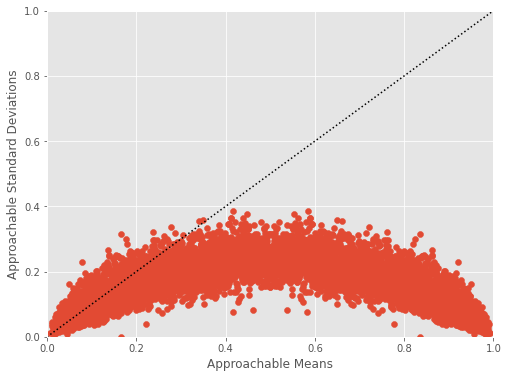

In [55]:
all_means = approach_df_mean.values.flatten()
all_stds = approach_df_std.values.flatten()

plt.figure(figsize=(8, 6))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(all_means, all_stds)
plt.plot([0, 1],":", c= "black" )
plt.xlabel("Approachable Means")
plt.ylabel("Approachable Standard Deviations");

For the most part, the means greater than the standard deviations which fills me with more confidence when interpreting analysis made on the means.

**Summary Stats and Distribution**

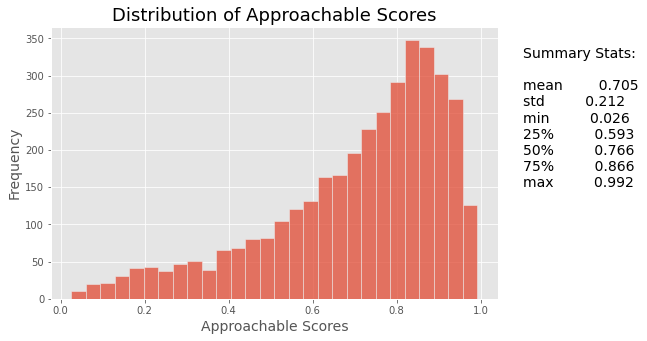

In [56]:
approach.dist_viz("approachable")

Given what I wrote earlier, this chart is quite surprising. It indicates that this model highly rates my music collection how accessible it is to the public. 

Now let's take a look at the five most and least approachable songs in the database.

In [59]:
approach.top_songs("approachable",n = 5)

,title,artist,approachable
sid,,,
bd8fba4e12551113b6bb28e30659cad3,I Love You (Extended),Karriem,0.992329
1b8532b6d23301b8ea16d82d7c33cba3,ouiness_zina_finished!,None,0.988984
c1becbc465751149b42ad8ebbe06d80c,"Şehrazat - Kendim ettim, kendim buldum (disco funk, Turkey 1981)",ultradiskopanorama,0.988932
b6f5a4b06bbd4279f4e8727a137bfe7f,Don't Let Me Down,Marcia Griffiths,0.988707
e68b85b8da0842ca44ad583b4d5cebea,Mioukouna,NST Cophie's,0.988692


My initial reaction here is skepticism. The songs listed above in the dataframe are certainly not the first songs in my catalog that I would nominate for approachability.

Have a listen and judge for yourself.

1. [I Love You (Extended) - Karriem](https://www.youtube.com/watch?v=kMpdZAuZu7M)

2. [Ouiness - Zina](https://www.youtube.com/watch?v=XIvIjTA1L_E)

3. [Kendim ettim, kendim buldum - Sehrazat](https://www.youtube.com/watch?v=UdICW7YqaoU)

4. [Don't Let Me Down - Marcia Griffiths](https://www.youtube.com/watch?v=dtpDmZpjsJE)

5. [Mioukouna -  N.S.T Cophie's](https://www.youtube.com/watch?v=vnfznqH7vQw)

I am perplexed when these songs made the top 10. At least of these tracks I wouldn't play in a typical gig, I'd only play them for a crowd I'm confident will appreciate relative obscure music.

Now let's look at the other side of the spectrum and see how the "unapproachable" songs stack up

In [60]:
approach.top_songs("approachable", ascending=True, n = 5)

,title,artist,approachable
sid,,,
67a5a54a5f62b597509e9d97eae584b3,Extra Vergine,Maus & Stolle,0.025874
a5e390371b3438d58800a9e8fa0332a1,Everybody,DISAIA,0.031497
b6b676e68093434e6c1e0e569b3dfdae,Voodoo Ray (Hey Dan Edit)_PN,A Guy Called Gerald,0.031578
f586f46de0a2df993f5823c2ccad4f96,Maurice - This is Acid (Sportello TB303 Edit),Sportello,0.034087
61f067aa07000144df9044ceedea72da,M4A4 - Raf,None,0.037901


1. [Extra Vergine - Maus & Stolle](https://www.youtube.com/watch?v=ykOCriwIatc)

2. [Everybody - DISAIA](https://www.youtube.com/watch?v=Z61TYWLGbck)

3. [Voodoo Ray (Hey Dan Edit) - A Guy Called Gerald](https://www.youtube.com/watch?v=clsB4bISUjc)

4. [This is Acid (Sportello TB303 Edit) - Maurice](https://sportellomusic.bandcamp.com/track/maurice-this-is-acid-sportello-tb303-edit)

5. [M4A4 - Raf](https://www.youtube.com/watch?v=q0sqLhu4vek)

There is a stark difference between the bottom and top sets of songs. The bottom ten are or similar to deep house and techno and are the type of songs soundtracking a stoic-faced audience. Whereas the top 10 songs are all funky and percolating buoyant and jovial vibes. 

Comparing the two sets of songs was helpful in advancing my understanding of how this model interprets approachability.

Most importantly I can definitely see myself using this metric in curating a set list.

**Danceability**

Pretty obvious definition here. However I am curious to see if genre influences the danceability scores. Does the model rate a funk/soul song at the same danceability level as a house song. 

More info ==> https://essentia.upf.edu/models.html#danceability


In [115]:
table = tables[1]
dance = ActivationDataHub(table_name=table)
dance.df.head()

Loading danceability_effnet_discogs_1_activations data


,danceable,not_danceable
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.9999424, 0.99976045, 0.99983895, 0.999848, 0.9999571, 0.9998455, 0.99988437, 0.9999192, 0.999...","[5.7582864e-05, 0.00023951827, 0.00016103889, 0.00015194346, 4.2891123e-05, 0.0001544856, 0.0001..."
46e54d2ab920a088b77382e04877141b,"[0.9999032, 0.9998369, 0.9999192, 0.99990785, 0.999863, 0.9996996, 0.99984634, 0.9998692, 0.9999...","[9.678665e-05, 0.0001630632, 8.081043e-05, 9.213655e-05, 0.00013701127, 0.000300486, 0.000153600..."
a204ddef5763df6d8f7677701fe9d96f,"[0.9981535, 0.9973373, 0.99670726, 0.99800974, 0.99799085, 0.99702066, 0.9951497, 0.99816823, 0....","[0.0018464968, 0.0026626734, 0.0032927275, 0.0019902333, 0.0020091475, 0.0029792786, 0.004850342..."
960097894e83c5810a9c649f17a4e551,"[0.999871, 0.9997358, 0.9998858, 0.99950945, 0.99984443, 0.9997348, 0.99975425, 0.9996364, 0.999...","[0.00012900884, 0.00026420056, 0.00011422723, 0.0004905543, 0.0001555365, 0.00026516986, 0.00024..."
a3c1f277aa0110ffc418bf5fa3aa16aa,"[0.69107103, 0.6084443, 0.5064755, 0.8155328, 0.6933056, 0.7086905, 0.43645376, 0.90993106, 0.90...","[0.30892897, 0.39155573, 0.49352455, 0.18446714, 0.3066944, 0.29130954, 0.56354624, 0.090068914,..."


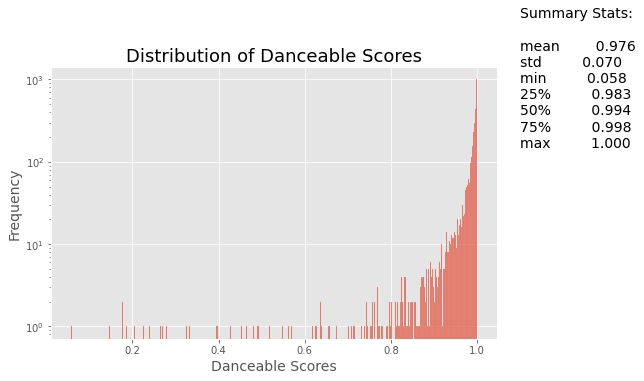

In [66]:
dance.dist_viz("danceable")
plt.yscale("log")


Not a big surprise that nearly every song in the database is rated highly on the danceability scale.

In fact, only 2% of songs have danceability scores lower than 0.8

In [70]:
np.mean(dance.df_mean.danceable<.8)

0.01985854189336235

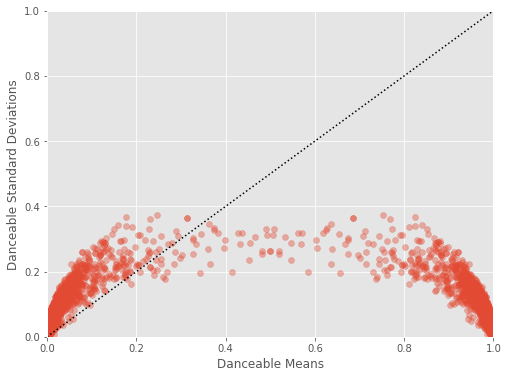

In [76]:
all_means = dance.df_mean.values.flatten()
all_stds = dance.df_std.values.flatten()

plt.figure(figsize=(8, 6))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(all_means, all_stds, alpha=.4)
plt.plot([0, 1],":", c= "black" )
plt.xlabel("Danceable Means")
plt.ylabel("Danceable Standard Deviations");

It's not worth showing the top danceable songs because it doesn't reveal anything new. However let's see what lies on the other side of the spectrum.

In [74]:
dance.top_songs("danceable",ascending=True, n = 5)

,title,artist,danceable
sid,,,
742d1fc3a38304122239d07244e0106e,Ende Beerabeero Rare Unknown Ethiopian Disco Modern Soul 45-785Pujxp7rU,Habte Awalom,0.058170
cea0eaff11847df1ef9fd641977527df,Mazhar Ve Fuat - Adimiz Miskindir Bizim (Mark Wayward Edit),Mark Wayward,0.069113
d7bfc278db4dbabfd1659252247c8899,J.J. Cale - RSDD003 - Social Distance Edits - 05 Lies (Mr. PC Belle Isle Balearic 12- Edit),None,0.147464
9aa0080ebc4cde62f3136f9786cdb7c3,Wede Harer Guzo,Hailu Mergia,0.175467
3c3f186cb9b2dd15804bf3995b65a34d,Lord Have Mercy,The Lijadu Sisters,0.176003


1. [Endebeerabeero - Habte Awalom](https://www.youtube.com/watch?v=785Pujxp7rU&ab_channel=JointCustody)

2. [Mazhar Ve Fuat Adimiz Miskindir Bizim (Mark Wayward Edit) - Mark Wayward](https://soundcloud.com/mark-wayward/mazhar-ve-fuat-adimiz-miskindir-bizim-mark-wayward-edit)

3. [J.J. Cale - RSDD003 - Social Distance Edits - 05 Lies (Mr. PC Belle Isle Balearic 12- Edit)	](https://petercroce.bandcamp.com/track/lies-mr-pc-belle-isle-balearic-12-edit)

4. [Wede Harer Guzo - Hailu Mergia](https://www.youtube.com/watch?v=wU_gcM7lmD8&ab_channel=AwesomeTapesFromAfrica)

5. [Lord Have Mercy - The Lijadu Sisters](https://www.youtube.com/watch?v=cYDwE9yFB_I&ab_channel=TheLijaduSisters-Topic)

For the most part, I agree with these assessments. These songs certainly won't bring the house down. I do feel like Endebeerabeero could be rated somewhat higher, but overall no issues with this data.

### Engagement

Music engagement predicting whether the music evokes active attention of the listener (high-engagement “lean forward” active listening vs. low-engagement “lean back” background listening).

More info => https://essentia.upf.edu/models.html#engagement

I have high hopes for this metric because of the simple reason that a good DJ plays "engaging" music. A key skill in DJing is assessing the energy level of their gigs. The engagement metric could be a useful proxy for energy. If I am playing a chiller, lowkey set then I could use engagement to help me assemble the right playlist of songs.

In [116]:
table = tables[2]
engage = ActivationDataHub(table_name=table)
engage.df.head()

Loading engagement_2c_effnet_discogs_1_activations data


,not_engaging,engaging
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.01610879, 0.03347205, 0.03819201, 0.0459898, 0.011230065, 0.029323494, 0.026065817, 0.0204776...","[0.9838912, 0.96652794, 0.96180797, 0.9540102, 0.9887699, 0.97067654, 0.9739342, 0.97952235, 0.9..."
46e54d2ab920a088b77382e04877141b,"[0.0025433216, 0.0068556145, 0.002352924, 0.0066941506, 0.0029510593, 0.012337105, 0.0041766968,...","[0.9974567, 0.9931444, 0.9976471, 0.99330586, 0.9970489, 0.98766285, 0.99582326, 0.9943621, 0.99..."
a204ddef5763df6d8f7677701fe9d96f,"[0.009494705, 0.025756417, 0.012806551, 0.021973863, 0.010267618, 0.02111152, 0.010153408, 0.018...","[0.9905053, 0.9742435, 0.9871934, 0.9780261, 0.9897323, 0.97888845, 0.9898465, 0.98158735, 0.986..."
960097894e83c5810a9c649f17a4e551,"[0.00086885516, 0.00088291627, 0.0010570403, 0.00079634396, 0.001559757, 0.0007735467, 0.0013624...","[0.99913114, 0.9991171, 0.99894303, 0.9992036, 0.9984402, 0.99922645, 0.9986375, 0.99925584, 0.9..."
a3c1f277aa0110ffc418bf5fa3aa16aa,"[0.59090894, 0.7070218, 0.62421054, 0.6648362, 0.5044175, 0.6665438, 0.67336226, 0.61193955, 0.5...","[0.40909111, 0.29297823, 0.37578952, 0.33516386, 0.49558252, 0.33345625, 0.3266378, 0.3880605, 0..."


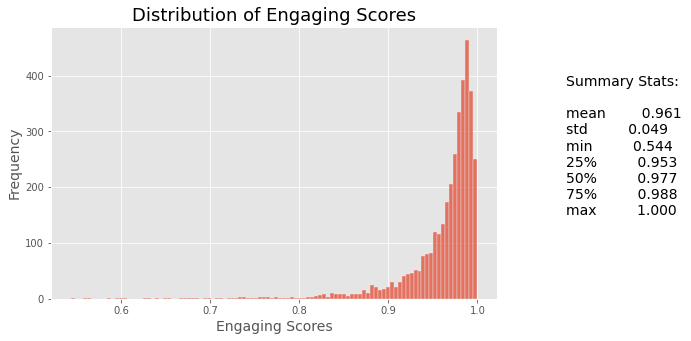

In [80]:
engage.dist_viz("engaging")

**Good news!**

Essentia's music engagement model thinks I am an engaging DJ. The vast majority of my songs have an average engaging score of greater than or equal to 0.9.

**Top 5 Engaging songs**

In [83]:
engage.top_songs("engaging",ascending=False, n = 5)

,title,artist,engaging
sid,,,
681ccf47549a629028cf97f8a816cfd7,Happy Song (Club Mix),Boney M,0.999690
0074bca61fc9947f1aae555d7f694139,Tchamy Patterson - First Man for Cry,reclusiv recordings,0.999632
bd8fba4e12551113b6bb28e30659cad3,I Love You (Extended),Karriem,0.999631
9124ded476f1e811c6b59b14a6d13bf5,"All My Life (12"" Funk 1983)",Major Harris,0.999548
138d96f7557b5abcc0483469f9f78b6e,DiscoGram - DG006 - 01 Dancing!_PN,None,0.999451


1. [Happy Song (Club Mix) - Boney M](https://www.youtube.com/watch?v=0_wf30gK9Pg&ab_channel=style300x)

2. [Tchamy Patterson - First Man for Cry - reclusiv recordings](https://www.youtube.com/watch?v=MAbUpL2bw08&ab_channel=LaboratoireTchamyPATTERSON)

3. [I Love You (Extended) - Karriem](https://www.youtube.com/watch?v=37sMZVsSxTs&ab_channel=FavoriteRecordings)

4. [All My Life (12" Funk 1983) - Major Harris](https://www.youtube.com/watch?v=qpcqQ8ifpRc&ab_channel=CoolfunkZ%C3%A9z%C3%A92)

5. [DiscoGram - DG006 - 01 Dancing!](https://www.youtube.com/watch?v=UvEZ1tQywTs&ab_channel=Funk%27nDisco%26Stuff)

The model isn't wrong here hand out high engagement appraisals for these five songs. What I am curious about is that the >0.999 mean engaging scores indicate that the model rates every section of each song as engaging.

**Bottom 5 engaging songs**

In [84]:
engage.top_songs("engaging",ascending=True, n = 5)

,title,artist,engaging
sid,,,
b85f2a4c63f48e712284262c7ff6ffbd,Automation - Workings Of A Madman Re-Mix,Tiny Magnetic Pets,0.543878
ed91d262dc3a679bac460f2f1d8b78ff,King Crimson - RSDD003 - Social Distance Edits - 11 The Sheltering Sky (Mr. PC Belle Isle Balear...,None,0.557839
9b69b0c8d5fdeee9e6950481d0caa1f1,Bubuj Bulan,Rully Djohan,0.562502
d71d4a7afde1a9891e56fe0fdf307aff,Azara alhai,Rasha,0.586922
540f1f587d15e9edc9ff5a2d82ab021b,Luiz Enrique - Mas Que Nada (Brasileiro Rework),Sonic Funk Foundry,0.588388


1. [Automation - Workings Of A Madman Re-Mix	Tiny Magnetic Pet](https://www.youtube.com/watch?v=X4I4LU04iCo&ab_channel=TinyMagneticPets-Topic)

2. [King Crimson - RSDD003 - Social Distance Edits - 11 The Sheltering Sky (Mr. PC Belle Isle Balear.]()

3. [Bubuj Bulan	Rully Djohan](https://www.youtube.com/watch?v=3a5IpOR24PQ&ab_channel=SoundwayRecords)

4. [Azara alhai	Rasha](https://www.youtube.com/watch?v=WOdcgc9ot3k&ab_channel=ZicZakGarage)

5. [Luiz Enrique - Mas Que Nada (Brasileiro Rework)	Sonic Funk Foundry](https://sonicfunkfoundry.bandcamp.com/track/luiz-enrique-mas-que-nada-brasileiro-rework)

This result confirms my hypothesis that engagement can be proxy a for energy (or at the very least correlates with it.)

All five of these songs are low-energy and are more appropriate for dinner parties than any gig I usually play.

### Danceability vs Engagement

Danceability and engagement appear to be strongly correlated (not entirely surprising tbh) so let's dive into this relationship.

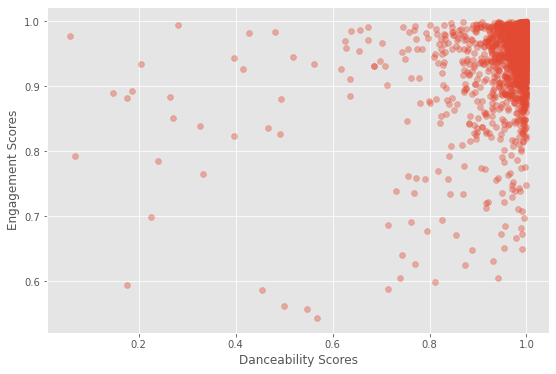

In [97]:
dance_means = dance.df_mean.danceable
engage_means = engage.df_mean.engaging
engage_dance = pd.concat([engage_means, dance_means], axis = 1)

plt.figure(figsize=(9, 6))
plt.scatter(engage_dance.danceable, engage_dance.engaging, alpha=.4)
plt.xlabel("Danceability Scores")
plt.ylabel("Engagement Scores");

Most of the songs are clustered in the top right corner, which tell us that engagement and danceability do indeed trend together.

89% of my songs have both danceable and engaging scores above or equal to 0.9

In [99]:
engage_dance.query("danceable >=.9 and engaging >=.9").shape[0]/engage_dance.shape[0]

0.8900979325353645

To learn how they differ from one another, I need to listen to high engaging/low danceable songs and low engaging/high danceable songs.

Here are songs with engaging scores >0.9 and danceable scores <0.5

In [106]:
high_engage_low_dance_songs = engage_dance.query("danceable <.5 and engaging >=.9")
tags.join(high_engage_low_dance_songs, how = "inner")[["title", "artist", "danceable", "engaging"]]

,title,artist,danceable,engaging
sid,,,,
f75e3622131ab738338fab375af88561,Amebo,The Lijadu Sisters,0.205313,0.934431
f34bbce6d615a660ef130647d9081d2c,I'M Feeling Sexy Tonight,Chona Cruz,0.481110,0.983108
49bb9fbb857a4d32f25227689fcf07fc,Won't Stop,DJ Snatch,0.428210,0.982285
ddf1c7208935bd59488b65b70bc4a432,Bi Kameleou,Volta Jazz,0.395995,0.943350
738ebd50ad5af9928b648385124ca9b3,16671686_Let_s Freak feat. Mr. V feat. Louie Vega_(Freak-A-Pella)_PN,None,0.414951,0.926072
742d1fc3a38304122239d07244e0106e,Ende Beerabeero Rare Unknown Ethiopian Disco Modern Soul 45-785Pujxp7rU,Habte Awalom,0.058170,0.977563
bcc2163e1ea5787c4d1f304607bd51ea,Disco Luismi (Edit de DiscoRollers)_PN,Various Artists,0.280143,0.993640


- [Amebo - The Lijadu Sisters](https://www.youtube.com/watch?v=-a3-mDAoNJM&pp=ygUUYW1lYm8gbGlqYWR1IHNpc3RlcnM%3D)

- [I'm Feeling Sexy Tonight - Chona Cruz](https://www.youtube.com/watch?v=RG57K_9y5Rc&ab_channel=Marc%27sOPMPlaylist)

- [Bi Kameleou - Volta Jazz](https://www.youtube.com/watch?v=tSOU38-0qsA&ab_channel=VoltaJazz-Topic)

- [Ende Beerabeero - Habte Awalom](https://www.youtube.com/watch?v=785Pujxp7rU&ab_channel=JointCustody)

- [Disco Luismi (Edit de DiscoRollers)](https://soundcloud.com/zhino/disco-luismi-discorollers)

It's correct to say that these songs won't make you bust a sweat on the dance floor but I can see why they're rate high on engaging. 

For example "I'm Feeling Sexy Tonight" showing up here makes sense because it's a slow-paced song yet incredibly fun song due to its catchy melody and hook. 

Now for high danceability and low engagement (danceable >.9 and engaging <.7)

In [107]:
low_engage_high_dance_songs = engage_dance.query("danceable >.9 and engaging <.7")
tags.join(low_engage_high_dance_songs, how = "inner")[["title", "artist", "danceable", "engaging"]]

,title,artist,danceable,engaging
sid,,,,
5b787eb97c0aeabca71a7a518ff5f57c,Marcos Valle - Água de Côco (Bernardo Pinheiro Edit),Bernardo Pinheiro,0.988168,0.681545
7b46a41051289c9bd3ae80d1eb0a788d,Bananeira da Ilha (cotait edit),África Tentação,0.977446,0.667144
f9a6e07d75b3f5c33db8f672b62d8401,Diálogo de Crioulos (Milton e Beto Chuquer Edit),None,0.931654,0.631613
31ab4708ffb4a57d52bac3613879cf22,Seven Windows - Danse Ralenti,reclusiv recordings,0.953039,0.651145
48c75551e75efc744602b9784bc10aeb,She,Those Guys From Athens,0.948289,0.673658
38e6a247694ad7cede598f46543107d0,Paperkraft - 私たちだけ何を話しているのか知っています。 - 04 B2. So deep in luv,None,0.990214,0.673340
c86eb429cf50cb8b138ac284b196c257,It's Music,Jex Opolis,0.991384,0.649430
5da5537a74d7311bec5964945d79db6b,Hashish (DJ Kobayashi Edit),Ibrahim Maalouf,0.994678,0.697119
1de80db15a46de00c6cbd06414e27b96,Bongosynth - Verão do Amor - 18 Gal Costa - A Mulher (De Sena Edit),None,0.940769,0.605812


- [Marcos Valle - Água de Côco (Bernardo Pinheiro Edit)](https://soundcloud.com/bernardopinheiro/marcos-valle-agua-de-coco-bernardo-pinheiro-edit)

- [Bananeira da Ilha (cotait edit)	África Tentação](https://rafaelcotait.bandcamp.com/track/frica-tenta-o-bananeira-da-ilha-cotait-edit)

- [Diálogo de Crioulos (Milton e Beto Chuquer Edit)](https://soundcloud.com/beto-chuquer/elza-soares-miltinho-e-som-tres-dialogo-de-crioulos-milton-e-beto-chuquer-edit)

- [Seven Windows - Danse Ralenti](https://www.youtube.com/watch?v=e_VXUX-kbVI&ab_channel=KeimiNewBeatCollector%2FOrgelAalst)

- [She	Those Guys From Athens](https://tooslowtodisco.bandcamp.com/track/she)

- [It's Music	Jex Opolis](https://www.youtube.com/watch?v=liBPbvUii0k&ab_channel=JexOpolis-Topic)

- [Hashish (DJ Kobayashi Edit)	Ibrahim Maalouf](https://djkobayashi.bandcamp.com/album/ibrahim-maalouf-hashish-dj-kobayashi-edit)

- [Bongosynth - Verão do Amor - 18 Gal Costa - A Mulher (De Sena Edit)](https://soundcloud.com/bongosynth/gal-costa-a-mulher-de-sena)

- [Lego Edit - Dancefloor Edits Afro Invasion - 05 The Trip (Lego Nu Edit Short Cut)](https://diegolellilegoedit.bandcamp.com/track/the-trip-lego-nu-edit-short-cut)

Based on this output, highly danceable and low engaging tracks are downtempo and lower energy. I don't really find these tracks all that danceable and they remind me lounge music.

### Acoustic music

More info => https://essentia.upf.edu/models.html#id459

I don't have any expectations here because "acoustic" is not a quality that factors significantly in a DJ's song selection. Nevertheless, I'm still curious to see how this model rates my song arsenal.

In [122]:
table_name = tables[3]
acoustic = ActivationDataHub(table_name=table_name)
acoustic.df.head(2)

Loading mood_acoustic_effnet_discogs_1_activations data


,acoustic,non_acoustic
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.0026928692, 0.0024666698, 0.003212599, 0.0026610964, 0.0019443267, 0.0017513653, 0.0031201968...","[0.9973072, 0.9975333, 0.9967874, 0.99733895, 0.9980557, 0.9982487, 0.9968798, 0.99778557, 0.987..."
46e54d2ab920a088b77382e04877141b,"[0.0010863945, 0.001686286, 0.0012730791, 0.0013222514, 0.0011042152, 0.0030583255, 0.0010868665...","[0.99891365, 0.9983138, 0.9987269, 0.9986777, 0.99889576, 0.9969416, 0.99891317, 0.9980895, 0.99..."


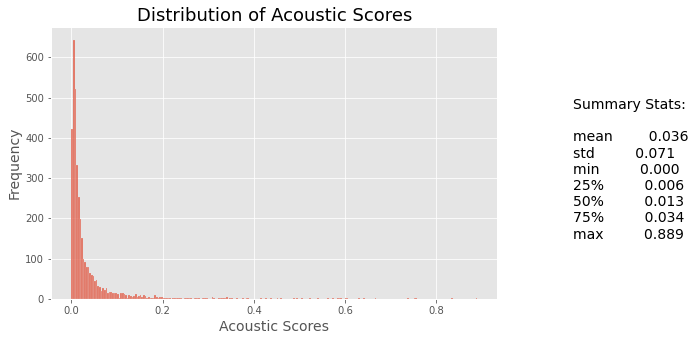

In [125]:
acoustic.dist_viz("acoustic")

About as surprising as the danceability plot

Let's just look at the top 5 acoustic songs.

In [126]:
acoustic.top_songs("acoustic", n= 5)

,title,artist,acoustic
sid,,,
d71d4a7afde1a9891e56fe0fdf307aff,Azara alhai,Rasha,0.889197
90c7378c60e273600d883d8b6cbab8a6,Telantena zare_PN,None,0.832715
cd54dcedd07842527ead1885aabf0e32,"Dhurata Dora -Ayo (Remix , Original Version) FULL VERSION",Culimusik,0.756565
3c3f186cb9b2dd15804bf3995b65a34d,Lord Have Mercy,The Lijadu Sisters,0.756202
3da006514008184513b3a9af4ca1e559,De Noite Na Cama,Erasmo Carlos,0.750305


1. [Azara alhai	Rasha](https://www.youtube.com/watch?v=WOdcgc9ot3k&ab_channel=ZicZakGarage)

2. [Telantena zare](https://www.youtube.com/watch?v=cJjZDxONGt0&ab_channel=ethiomelaku2)

3. [Dhurata Dora - Ayo Remix](https://music.youtube.com/watch?v=pd_OZgsRSiY)

4. [Lord Have Mercy	The Lijadu Sisters](https://www.youtube.com/watch?v=2LOUSR7jk-k&ab_channel=TheLijaduSisters)

5. [De Noite Na Cama	Erasmo Carlos](https://www.youtube.com/watch?v=7ZZTn6Cs06Y&ab_channel=DaniloSousRodrigues)

Every song exept Ayo by Dhurata Dora squarely falls under the acoustic umbrella. I don't know how Ayo could be considered acoustic

### Aggressive

More info => https://essentia.upf.edu/models.html#id471

I'm not sure exactly sure how aggressive could be useful to me. Disco, boogie and house aren't really "aggressive" in the way that tech-house, techno, and dubstep are. 

In [130]:
table_name = tables[4]
agg = ActivationDataHub(table_name=table_name)
agg.df.head()

Loading mood_aggressive_effnet_discogs_1_activations data


,aggressive,not_aggressive
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.034215257, 0.07423435, 0.018835252, 0.03975891, 0.015497063, 0.049738754, 0.01714708, 0.07089...","[0.9657847, 0.92576563, 0.9811647, 0.96024114, 0.984503, 0.95026124, 0.9828529, 0.92910177, 0.99..."
46e54d2ab920a088b77382e04877141b,"[0.54076356, 0.3211906, 0.2659027, 0.5022463, 0.52893263, 0.38220552, 0.408414, 0.4466769, 0.341...","[0.45923647, 0.67880934, 0.73409724, 0.49775374, 0.47106734, 0.61779445, 0.591586, 0.5533231, 0...."
a204ddef5763df6d8f7677701fe9d96f,"[0.04164454, 0.030356685, 0.025491077, 0.021721967, 0.067210406, 0.029821342, 0.032328323, 0.031...","[0.9583555, 0.9696433, 0.97450894, 0.97827804, 0.9327896, 0.97017866, 0.96767163, 0.9684976, 0.9..."
960097894e83c5810a9c649f17a4e551,"[0.053191595, 0.02566131, 0.05958791, 0.039445955, 0.039067335, 0.04302546, 0.029958572, 0.04152...","[0.9468084, 0.9743387, 0.94041204, 0.96055406, 0.9609327, 0.9569745, 0.97004145, 0.9584721, 0.99..."
a3c1f277aa0110ffc418bf5fa3aa16aa,"[0.030829221, 0.023007683, 0.021254605, 0.02481825, 0.040518463, 0.032081258, 0.010878027, 0.006...","[0.96917075, 0.97699225, 0.97874546, 0.97518176, 0.95948154, 0.96791875, 0.989122, 0.9930773, 0...."


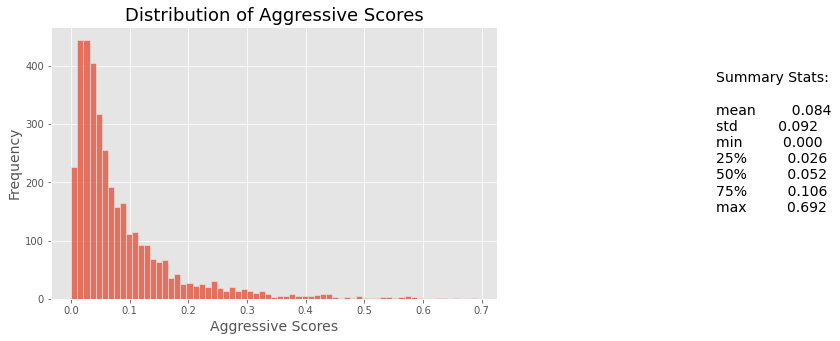

In [131]:
agg.dist_viz("aggressive")

Not a whole lot of aggression present in my oeuvre.

What are the top 5 most aggressive songs?

In [132]:
agg.top_songs("aggressive", n = 5)

,title,artist,aggressive
sid,,,
84e054c6294d8496a53dd81a6020b02d,Break,Nick Garcia,0.692492
c4c3b598c63b9de8950c44cacdfc20aa,Dino Soccio - Pleasure of Edits 07 - 03 Bump Theme (edit),None,0.658096
1ac21451b49daf78ed89a4d4774fe652,Lords Of The Future,Lords Of The Future,0.654220
01d99c36d2c6ff654e7833c3fc20a17b,Gil Dobrica - O Strada Mai Ingusta (Iorga Edit),IORGA,0.632745
8d594188e7461f1661e0c7c06693c75a,Spacer Woman (Roliva Edit),"Roliva, Charlie",0.630386


1. [Break - Nick Garcia](https://houseofboom.bandcamp.com/track/break)

2. [Dino Soccio - Pleasure of Edits 07 - 03 Bump Theme (edit)](https://dinosoccio.bandcamp.com/album/pleasure-of-edits-07)

3. [Lords Of The Future - Lords Of The Future](https://www.youtube.com/watch?v=jiUSAce3dXM&ab_channel=ElectronicLoveCollective)

4. [Gil Dobrica - O Strada Mai Ingusta (Iorga Edit)](https://iorga.bandcamp.com/track/gil-dobrica-o-strada-mai-ingusta-iorga-edit)

5. [Spacer Woman (Roliva Edit) - Roliva, Charlie](https://www.youtube.com/watch?v=xwk7rV-AUE0&ab_channel=DennisHultsch)

Based on this output, "aggressive" in the context of my song collection means electronic music with prominent synthy jabs and hits. "Break" and "Spacer Woman" are valid selections based on essentia's aggressive criteria.

### Happy

At a basic level, the metrics we've assessed so far adhere to a low energy-high energy spectrum. But sometimes energy isn't enough. Take for instance a sunny day party; that's is a scenario where both low energy and high energy songs can fit in. To me, what makes an appropriate day party song is how buoyant and uplifting it is. You wouldn't want to hear dour music a day party at the park or on a boat. 

That's where "happy" could possibly be of assistance. I could use this rating to select songs for more jovial occassions such as day parties. I think "happy" has the potential to add a critical and different dimension to low to high energy spectrum.

More info => https://essentia.upf.edu/models.html#id495

In [136]:
table_name = tables[5]
happy = ActivationDataHub(table_name)
happy.df.head()

Loading mood_happy_effnet_discogs_1_activations data


,happy,non_happy
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.36340898, 0.18219845, 0.3428177, 0.19498937, 0.39566082, 0.17289302, 0.40052393, 0.20453341, ...","[0.636591, 0.81780154, 0.6571822, 0.8050107, 0.60433924, 0.82710695, 0.599476, 0.7954666, 0.9311..."
46e54d2ab920a088b77382e04877141b,"[0.09185828, 0.08827926, 0.10759978, 0.09465805, 0.06764625, 0.08693469, 0.06990745, 0.15041173,...","[0.90814173, 0.9117208, 0.89240026, 0.905342, 0.9323538, 0.9130654, 0.9300926, 0.8495883, 0.9147..."
a204ddef5763df6d8f7677701fe9d96f,"[0.5078719, 0.3578924, 0.51367694, 0.39432797, 0.5174208, 0.41941053, 0.6050827, 0.44703227, 0.5...","[0.4921281, 0.6421076, 0.4863231, 0.60567206, 0.4825791, 0.58058953, 0.3949173, 0.5529677, 0.454..."
960097894e83c5810a9c649f17a4e551,"[0.8064001, 0.78968686, 0.8094659, 0.80943507, 0.8025667, 0.7954887, 0.79991245, 0.8111683, 0.73...","[0.19359986, 0.21031311, 0.19053414, 0.19056496, 0.19743326, 0.20451134, 0.20008764, 0.18883172,..."
a3c1f277aa0110ffc418bf5fa3aa16aa,"[0.04381575, 0.05092577, 0.059241563, 0.054157313, 0.05069841, 0.03254329, 0.09770478, 0.0511871...","[0.9561842, 0.9490742, 0.94075847, 0.9458427, 0.9493016, 0.9674567, 0.90229523, 0.94881284, 0.90..."


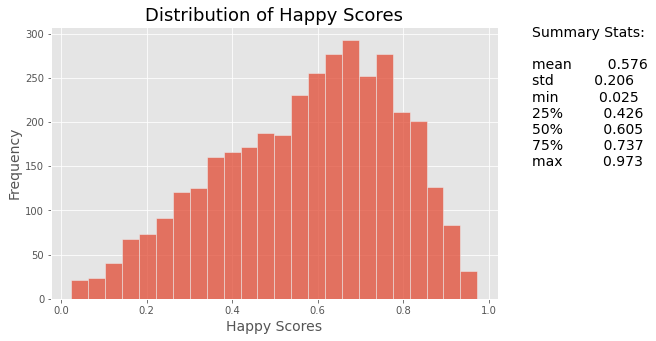

In [137]:
happy.dist_viz("happy")

So far the closest distribution we've seen to a normal one and the closest 0.5.

The distribution feels right to me, I would've guessed that on average my songs are closer to totally happy than to totally not happy.

Top 5 happiest songs

In [138]:
happy.top_songs("happy", 5)

,title,artist,happy
sid,,,
b6f5a4b06bbd4279f4e8727a137bfe7f,Don't Let Me Down,Marcia Griffiths,0.972735
3746f02034387a50e5768211a47d055d,Act of Sedition - Tropical Punch - 03 The Peanut Man - DJ Laurel edit,None,0.971720
297a8b8f471264e63e8a67274e100782,Dance Motif - Stages (Dance Motif Edit),None,0.968240
b0be8c3bac085b48721c78a4940870cf,Harry Mwale — Pretty Face (Tambourine Party Edit)-YdrHvFAcPf8,None,0.965730
b085951a81e3078f4b114d1ffc5e80b5,The Boogashake,MARIO ALLISON Y SU COMBO,0.965116


1. 